In [1]:
import os
# Set the number of threads for OpenMP to 1 to avoid multithreading issues
os.environ["OMP_NUM_THREADS"] = '1'

import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import pandas for data manipulation and analysis
import seaborn as sns  # Import seaborn for advanced data visualization
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import matplotlib.ticker as ticker  # Import ticker for customizing matplotlib ticks
import scipy.optimize as opt  # Import scipy.optimize for curve fitting
import errors as err  # Custom module for error propagation (assumed to exist)
from sklearn.preprocessing import MinMaxScaler  # Import MinMaxScaler for feature scaling
import cluster_tools as ct  # Custom clustering utilities module (assumed to exist)
from sklearn.cluster import KMeans  # Import KMeans for clustering
from sklearn.metrics import silhouette_score  # Import silhouette_score for clustering quality assessment

# Suppress pandas warnings about chained assignment
pd.options.mode.chained_assignment = None


In [2]:
def number_to_k_m(x, pos):
    """Convert numbers to 'K' for thousands or 'M' for millions."""
    if x >= 1_000_000:
        return f'{x / 1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x / 1_000:.1f}K'
    else:
        return int(x)


In [3]:
def plot_with_annotations(df, x_col, y_col, title='', xlabel='', ylabel='', palette='viridis'):
    """
    Plots a bar graph with annotations using seaborn and matplotlib.

    Args:
    df (pandas.DataFrame): DataFrame containing the data to plot.
    x_col (str): Name of the column to use as x-axis.
    y_col (str): Name of the column to use as y-axis.
    title (str, optional): Title of the plot.
    xlabel (str, optional): Label for the X-axis.
    ylabel (str, optional): Label for the Y-axis.
    palette (str, optional): Color palette for the bars.
    """
    # Create the plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    barplot = sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

    barplot.yaxis.set_major_formatter(ticker.FuncFormatter(number_to_k_m))

    # Add labels to the bars
    for p in barplot.patches:
        barplot.annotate(number_to_k_m(p.get_height(), None),  # Using thousands separator
                         (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the text
                         ha='center', va='center',  # Center alignment
                         xytext=(0, 10),  # Position text 10 points above the bar
                         textcoords='offset points')  # Use offset points for positioning

    # Set labels and title
    plt.xlabel(xlabel)  # X-axis label
    plt.ylabel(ylabel)  # Y-axis label
    plt.title(title)  # Title of the plot
    plt.savefig('Bar.png', dpi=300)
    # Show the plot
    plt.show()


In [4]:
def visualize_correlation_matrix(df, title='Correlation Matrix', cmap='viridis', show_values=True, figsize=(10, 8)):
    """
    Plots the correlation matrix for the given DataFrame without using a mask.

    Args:
    df (pandas.DataFrame): The DataFrame whose correlation matrix will be plotted.
    title (str, optional): Title of the plot.
    cmap (str, optional): Colormap of the correlation matrix.
    show_values (bool, optional): Whether to show the correlation coefficients in the plot.
    figsize (tuple, optional): Figure size given as (width, height).
    """
    # Calculate the correlation matrix
    corr = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)
    sns.set(style='white')  # white background style for seaborn plots

    # Draw the heatmap
    heatmap = sns.heatmap(corr, annot=show_values, fmt=".2f", cmap=cmap,
                          cbar_kws={'shrink': .5}, linewidths=.5, square=True)

    # Configure the tick labels for better readability
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

    # Set plot title
    plt.title(title)
    plt.savefig('correlation matrix.png', dpi=300)
    # Show the plot
    plt.show()


In [5]:
def draw_scatter_plot(df, x_col, y_col, with_regression=False, title='', xlabel='', ylabel='', color='green', marker='x', figsize=(8, 6)):
    """
    Plots a scatter plot of two variables from a DataFrame, with an optional regression line.

    Args:
    df (pandas.DataFrame): The DataFrame containing the data.
    x_col (str): Column name to be used for the x-axis.
    y_col (str): Column name to be used for the y-axis.
    with_regression (bool, optional): If True, include a regression line in the plot.
    title (str, optional): Title of the plot.
    xlabel (str, optional): Label for the x-axis.
    ylabel (str, optional): Label for the y-axis.
    color (str, optional): Color of the plot points.
    marker (str, optional): Marker style of the plot points.
    figsize (tuple, optional): Figure size, given as (width, height).
    """
    # Setup the plot
    plt.figure(figsize=figsize)
    sns.set(style='darkgrid')  # Setting the style of the plot

    # Scatter plot with or without regression line
    if with_regression:
        sns.regplot(x=x_col, y=y_col, data=df, scatter_kws={'color': color, 'marker': marker})
    else:
        plt.scatter(df[x_col], df[y_col], color=color, marker=marker)

    # Set plot labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig('scatter plot.png', dpi=300)
    # Show the plot
    plt.show()

In [6]:
def evaluate_silhouette_scores(data, max_clusters=10):
    """
    Evaluate and plot silhouette scores for different numbers of clusters.

    Parameters:
    - data: The input data for clustering.
    - max_clusters: The maximum number of clusters to evaluate.

    Returns:
    """

    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        # Perform clustering using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='s', color='red')
    plt.title('Silhouette Score for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.savefig('silhouette_score.png', dpi=300)
    plt.show()


In [7]:
def prepare_data_for_bar_chart(cols, ind, dataframes, year):
    """
    Retrieves and transforms data for a specific year from a list of dataframes for bar chart visualization.

    This function selects a dataframe from a list by index, then filters for specific columns and the given year.
    It transposes the dataframe to switch rows and columns, sets the year as the column header, and ensures
    the data is of float type, making it suitable for plotting a bar chart.

    Parameters:
    - cols (list of str): Column names to be retained for the bar chart.
    - ind (int): Index of the dataframe in the list to be processed.
    - dataframes (list of pandas.DataFrame): List containing the dataframes to be processed.
    - year (str): The year for which the data is to be retrieved.

    Returns:
    - pandas.DataFrame: A transposed DataFrame with the selected year's data ready for bar chart plotting.
    """
    df = dataframes[ind]
    df = df[cols]
    df = df[df['Year'] == year]
    df_t = df.T
    df_t.columns = df.Year
    df_t = df_t.astype(float)
    return df_t


In [8]:
def prepare_data_for_heatmap(indicators, data_frames, country):
    """
    Prepare data for heatmap visualization by processing indicators for a specific country.

    Parameters:
    - indicators : list of str
        Names of indicators with optional details in parentheses.
    - data_frames : list of pandas.DataFrame
        DataFrames containing data for indicators.
    - country : str
        The country for which data is extracted.

    Returns:
    - pandas.DataFrame
        Processed data ready for heatmap visualization.
    """
    data_dic = {}
    for ind in range(len(indicators)):
        data = data_frames[ind]
        data = data[country]
        column_means = data.mean()
        data = data.fillna(column_means)
        data_dic[indicators[ind].split('(')[0].strip()] = data.tolist()
    df = pd.DataFrame(data_dic)

    return df


In [9]:
def perform_kmeans_clustering(df, ind1, ind2, xlabel, ylabel, title, n_clusters, df_fit, df_min, df_max, new_data, new_df):
    """
    Performs KMeans clustering on provided data, plots the clusters, and annotates cluster centers.

    This function fits a KMeans clustering model to the 'df_fit' dataset and uses this model to predict
    clusters for both original and new datasets. It generates a plot that shows the original data points,
    new data points, and cluster centers with annotations.

    Parameters:
    - df : pandas.DataFrame
        The original dataset containing the data points.
    - ind1, ind2 : str
        Column names in 'df' which are used for the x and y axes of the plot.
    - xlabel, ylabel : str
        Labels for the x and y axes of the plot.
    - title : str
        Title of the plot.
    - n_clusters : int
        Number of cluster centers for KMeans clustering.
    - df_fit : pandas.DataFrame
        The dataset used to fit the KMeans model.
    - df_min, df_max : numpy.array
        Arrays containing the minimum and maximum values used for data scaling.
    - new_data : numpy.array
        New data points to be predicted by the KMeans model.
    - new_df : pandas.DataFrame
        DataFrame containing new data points for plotting.

    Returns:
    None. Generates and displays a scatter plot and saves it to a PNG file.

    Notes:
    - The 'ct.backscale' function is assumed to rescale the cluster centers back to their original scale.
    - The plot includes three scatter plots: one for original data, one for new data, and one for cluster centers.
    - Each cluster center is annotated with its respective group number directly in the plot.
    """
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    kmeans.fit(df_fit)  # Fit model on initial data

    # Extract labels and cluster centers from the fitted model
    labels = kmeans.labels_
    cen = kmeans.cluster_centers_

    # Prepare plot
    plt.figure(figsize=(8, 8))

    # Scatter plot for original data
    original_scatter = plt.scatter(df[ind1], df[ind2], c=labels, cmap="tab10", label='Original Data')

    # Predict clusters for new data and plot
    new_labels = kmeans.predict(new_data)  # Predicting clusters for new data based on the fitted model
    new_data_scatter = plt.scatter(new_df[ind1], new_df[ind2], c=new_labels, cmap="tab10", marker="s", label='New Data')

    # Rescale and show cluster centers
    scen = ct.backscale(cen, df_min, df_max)  # Assuming 'ct.backscale' is a function you've defined elsewhere for rescaling
    xc = scen[:, 0]
    yc = scen[:, 1]
    centers_scatter = plt.scatter(xc, yc, c="k", marker="d", s=80, label='Cluster Centers')  # Black diamonds for cluster centers

    # Annotate cluster centers with their respective group numbers
    for i, (x, y) in enumerate(zip(xc, yc)):
        plt.annotate(f'Group {i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Add legend, labels, title, and save the plot
    plt.legend(handles=[original_scatter, new_data_scatter, centers_scatter], title="Clusters")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('Clustering_plot.png', dpi=300)
    plt.show()

In [10]:
def logistics(t, a, k, t0):
    """ Computes logistics function with scale and incr as free parameters
    """
    f = a / (1.0 + np.exp(-k * (t - t0)))
    return f

In [11]:
def forecast_with_logistic_model(df, country_name, ind, title_fit, title_forecast, initial_guess):
    """
    Fit a logistic model to the data for a specified country and predict future values.

    Parameters:
    - df : pandas.DataFrame
        Data containing the population (or other indicator) indexed by year.
    - country_name : str
        The name of the country to analyze (column name in `df`).
    - ind : str
        Indicator name for the y-axis label.
    - title_fit : str
        Title for the fitting plot.
    - title_forecast : str
        Title for the forecast plot.
    - initial_guess : list or tuple
        Initial guess for logistic model parameters.

    Outputs:
    - Saves two plots as PNG files:
        1. `{country_name}b.png`: Logistic fit plot.
        2. `{country_name}b_forecast.png`: Forecast plot with error bounds.
    """
    # Fit the model
    popt, pcorr = opt.curve_fit(logistics, df.index, df[country_name], p0=initial_guess)
    df["pop_log"] = logistics(df.index, *popt)

    # Plot the fitted data
    plt.figure()
    plt.plot(df.index, df[country_name], label="Data")
    plt.plot(df.index, df["pop_log"], label="Fit")
    plt.legend()
    plt.xlabel('Years')
    plt.ylabel(ind)
    plt.title(title_fit)
    plt.savefig(country_name + 'b.png', dpi=300)

    # Prepare for forecast plotting
    years = np.linspace(df.index.min(), 2030)
    pop_log = logistics(years, *popt)
    sigma = err.error_prop(years, logistics, popt, pcorr)
    low = pop_log - sigma
    up = pop_log + sigma

    # Plot the forecast with error ranges
    plt.figure()
    plt.title(title_forecast)
    plt.plot(df.index, df[country_name], label="Data")
    plt.plot(years, pop_log, label="Forecast")
    plt.fill_between(years, low, up, alpha=0.5, color="y")
    plt.legend(loc="upper left")
    plt.xlabel('Years')
    plt.ylabel(ind)
    plt.savefig(country_name + 'b_forecast.png', dpi=300)
    plt.show()

In [12]:
def process_indicator_data(df, indicators):
    """
    Refine and structure data for specified indicators from a DataFrame.

    Parameters:
    - df : pandas.DataFrame
        Input DataFrame with 'Indicator Name' column and yearly data.
    - indicators : list of str
        Indicators to filter and process.

    Returns:
    - list of pandas.DataFrame
        Each DataFrame corresponds to a specified indicator, with years as rows and values as columns.
    """
    dataframes = []
    for ind in indicators:
        data = df[df['Indicator Name'] == ind]
        data = data.drop('Indicator Name', axis=1)
        data = data.T
        data.columns = data.iloc[0]
        data = data.drop(['Country Name'])
        data = data.astype(float)
        data['Year'] = data.index
        data = data.reset_index(drop=True)
        dataframes.append(data)

    return dataframes


In [13]:
def filter_country_data(df, country_name, start_year, end_year):
    """
    Filter and prepare data for a specific country within a year range.

    Parameters:
    - df (pandas.DataFrame):
        Input DataFrame containing 'Year' and country-specific data.
    - country_name (str):
        Name of the country column to extract data for.
    - start_year (int):
        Start year for filtering.
    - end_year (int):
        End year for filtering.

    Returns:
    - pandas.DataFrame:
        DataFrame indexed by 'Year' with data for the specified country and time frame.
    """
    df = df[['Year', country_name]]
    df['Year'] = df['Year'].astype(int)
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    df = df.fillna(0)
    df = df.set_index('Year')
    return df

In [15]:
selected_indicators = ["Agricultural land (sq. km)", "Population, total", "Forest area (sq. km)", "CO2 emissions (kt)", "Urban population"]
world_climate_data = pd.read_csv('/content/drive/MyDrive/Datasets/World_Climate data.csv', skiprows=4)
world_climate_data = world_climate_data[world_climate_data['Indicator Name'].isin(selected_indicators)]
world_climate_data = world_climate_data.drop(['Country Code', 'Indicator Code', 'Unnamed: 67'], axis=1)
data_frames = process_indicator_data(world_climate_data, selected_indicators)

<ipython-input-3-fe3745d89eee>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x_col, y=y_col, data=df, palette=palette)


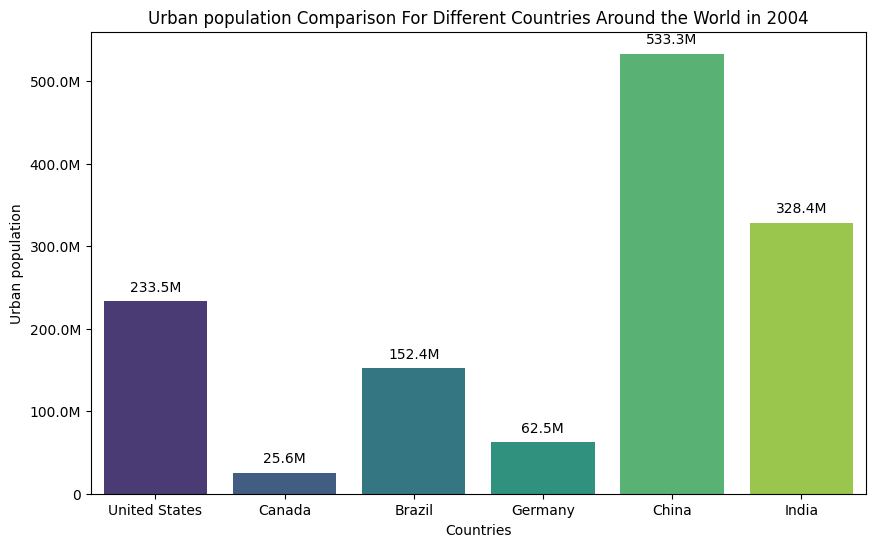

In [16]:
cols = ['United States', 'Canada', 'Brazil', 'Germany', 'China', 'India', 'Year']
bar_2004 = prepare_data_for_bar_chart(cols, 4, data_frames, '2004')
bar_2014 = prepare_data_for_bar_chart(cols, 4, data_frames, '2014')
plot_with_annotations(bar_2004.iloc[:-1], bar_2004.index[:-1], '2004', 'Urban population Comparison For Different Countries Around the World in 2004', 'Countries', 'Urban population')


<ipython-input-3-fe3745d89eee>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x_col, y=y_col, data=df, palette=palette)


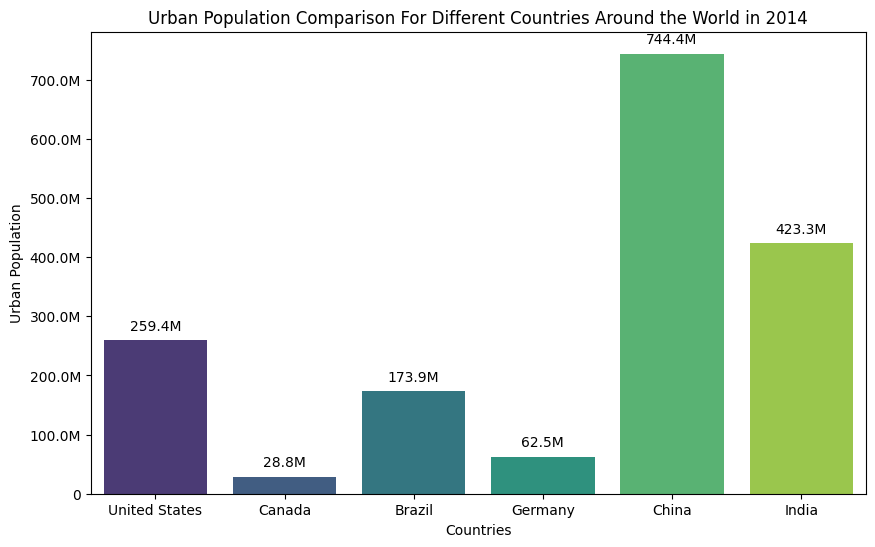

In [17]:
plot_with_annotations(
    bar_2014.iloc[:-1],
    bar_2014.index[:-1],
    '2014',
    'Urban Population Comparison For Different Countries Around the World in 2014',
    'Countries',
    'Urban Population'
)

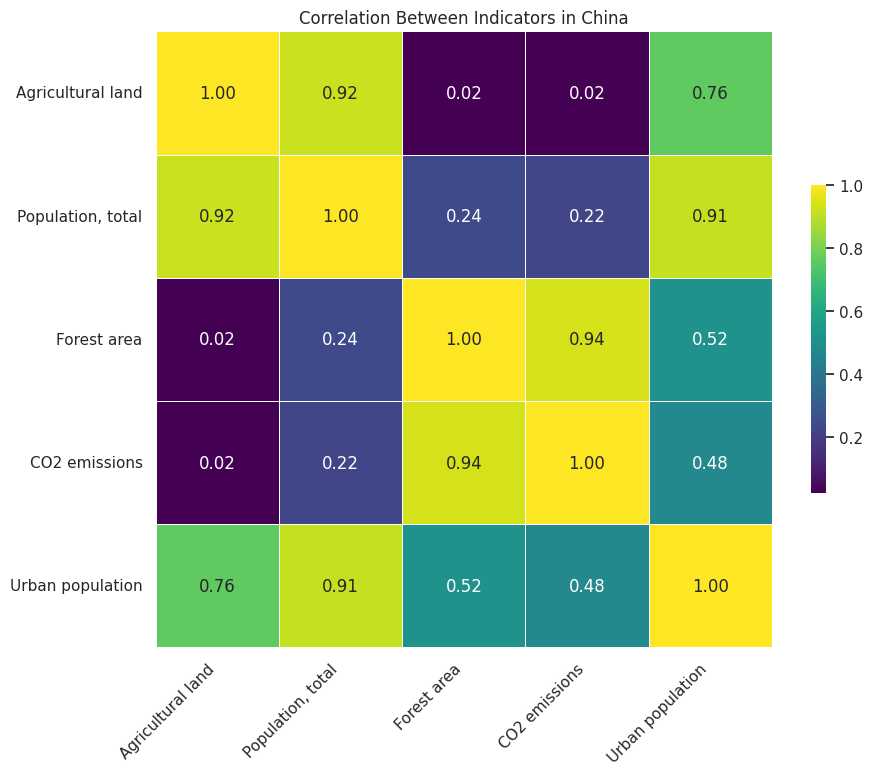

In [19]:
df = prepare_data_for_heatmap(selected_indicators, data_frames, 'China')
visualize_correlation_matrix(df, 'Correlation Between Indicators in China')

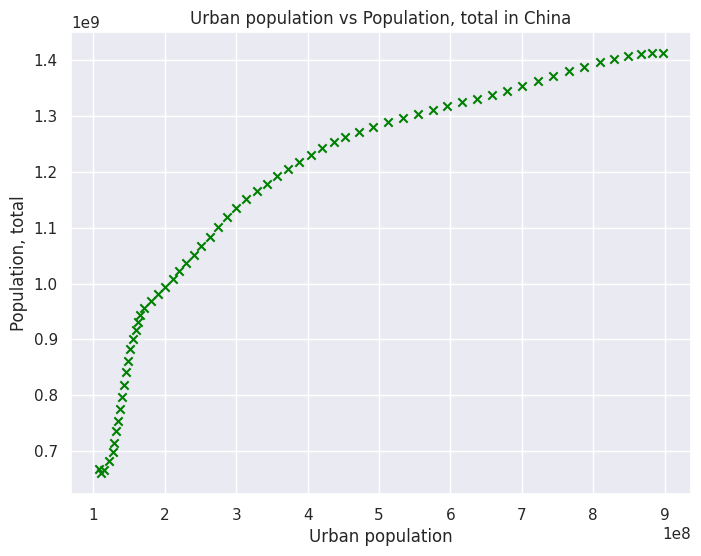

In [28]:
draw_scatter_plot(
    df,
    'Urban population',
    'Population, total',
    with_regression=False,
    title='Urban population vs Population, total in China',
    xlabel='Urban population',
    ylabel='Population, total'
)

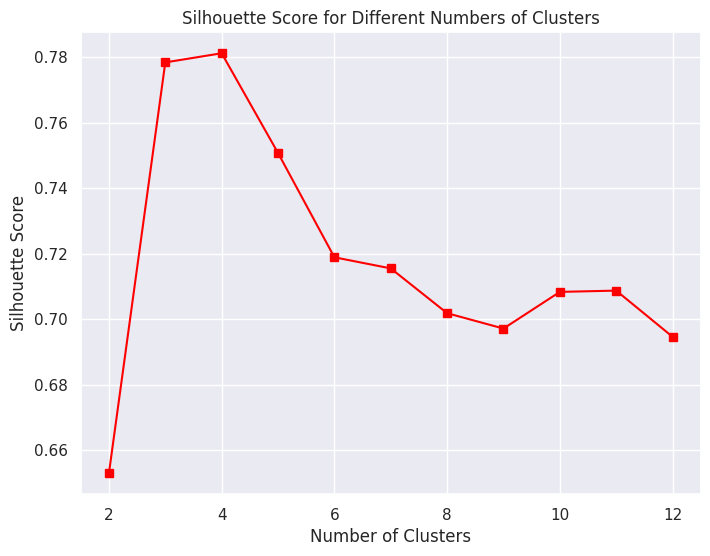

In [23]:
df_selected = df[['CO2 emissions', 'Forest area']]
train_df = df.sample(frac=0.9, random_state=42)  # Random state for reproducibility
test_df = df.drop(train_df.index)
scaled_df, df_min, df_max = ct.scaler(df_selected)
train_scaled_df = scaled_df.sample(frac=0.9, random_state=42)  # Random state for reproducibility
test_scaled_df = scaled_df.drop(train_df.index)

evaluate_silhouette_scores(scaled_df, max_clusters=12)

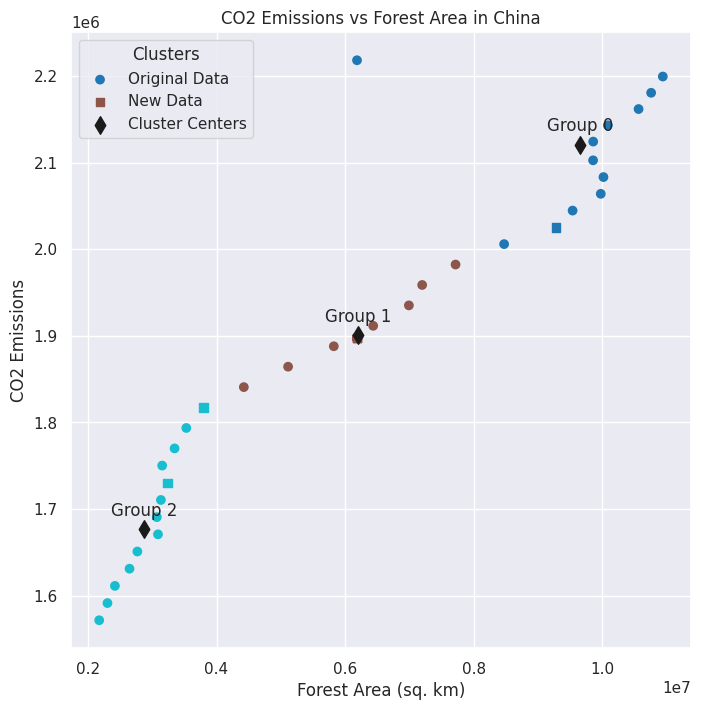

In [26]:
perform_kmeans_clustering(
    train_df,
    'CO2 emissions',
    'Forest area',
    'Forest Area (sq. km)',
    'CO2 Emissions',
    'CO2 Emissions vs Forest Area in China',
    3,
    train_scaled_df,
    df_min,
    df_max,
    test_scaled_df,
    test_df
)


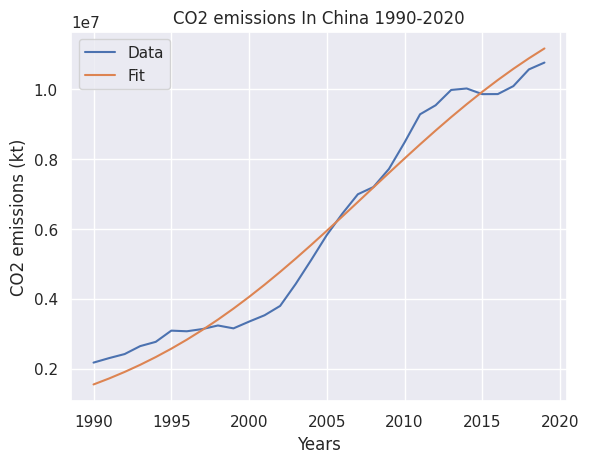

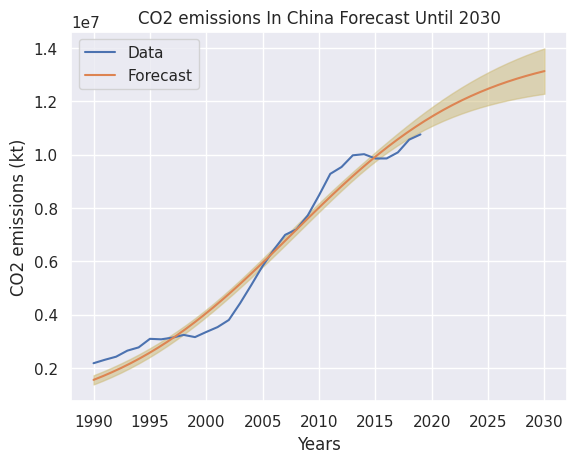

In [27]:
forecast_with_logistic_model(
    filter_country_data(data_frames[3], 'China', 1990, 2019),
    'China',
    'CO2 emissions (kt)',
    "CO2 emissions In China 1990-2020",
    "CO2 emissions In China Forecast Until 2030",
    (10e6, 0.5, 1990.0)
)
